# Building a Recommendation System Using CNN 
![](https://www.researchgate.net/profile/Andreas_Veit/publication/282181243/figure/fig1/AS:360995122892808@1463079352720/Visualization-of-a-2D-embedding-of-the-style-space-trained-with-strategic-sampling.png)



## Introduction

In this notebook, I will use a CNN Model to create a Fashion Embedding. This information can be used in ML algorithms with higher semantic quality and similarity between Objects. We will use embeddings to identify similar items, this information will be used to recommend similar content in RecSys.

* **Introduction**
    * What is Embedding ?
    * How to use Embedding ?
* **Data Preparation**
* **Use Pre-Trained Model to Recommendation**
* Visualization Latent Space of Contents

#### Configure VM

In [1]:
#!pip install swifter
#!pip install tensorflow==2.0.0

In [5]:
print('haha')

haha


## What is Embedding ?

An embedding is a relatively low-dimensional space into which you can translate high-dimensional vectors. Embeddings make it easier to do machine learning on large inputs like sparse vectors representing words. Ideally, an embedding captures some of the semantics of the input by placing semantically similar inputs close together in the embedding space. An embedding can be learned and reused across models.

So a natural language modelling technique like Word Embedding is used to map words or phrases from a vocabulary to a corresponding vector of real numbers. As well as being amenable to processing by learning algorithms, this vector representation has two important and advantageous properties:

* **Dimensionality Reduction** — it is a more efficient representation
* **Contextual Similarity** — it is a more expressive representation

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSiR683wW4f9httU7krJeLcgDQRB3Fmxi4v2SIr8QLSht204cmk&s)

We can use the Embedding as input of the model, containing a reduced dimensionality but with much semantic information. 

## Data Preparation
To begin this exploratory analysis, first use `matplotlib` to import libraries and define functions for plotting the data.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure

In [2]:
os.listdir('D:\machine-learning')

['datasets']

In [3]:
DATASET_PATH = 'D:\machine-learning\datasets\\fashion-product-images-small'
print(os.listdir(DATASET_PATH))

['images', 'myntradataset', 'styles.csv']


In [4]:
df = pd.read_csv(DATASET_PATH + "\styles.csv", nrows=5000, error_bad_lines=False)
print(df.keys())
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
print(df.keys())
df = df.reset_index(drop=True)
df.head(10)

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')
Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
      dtype='object')


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch,30039.jpg


In [19]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img):
    return DATASET_PATH + '\images\\' + img

def load_image(img, resized_fac = 1):
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return resized

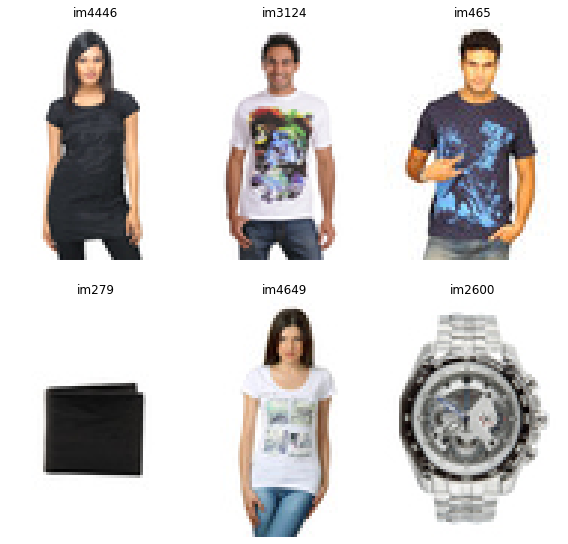

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.sample(6).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

The Dataset is made up of different items that can be found in a marketplace. The idea is to use embeddings to search for similarity and find similar items just using the image.

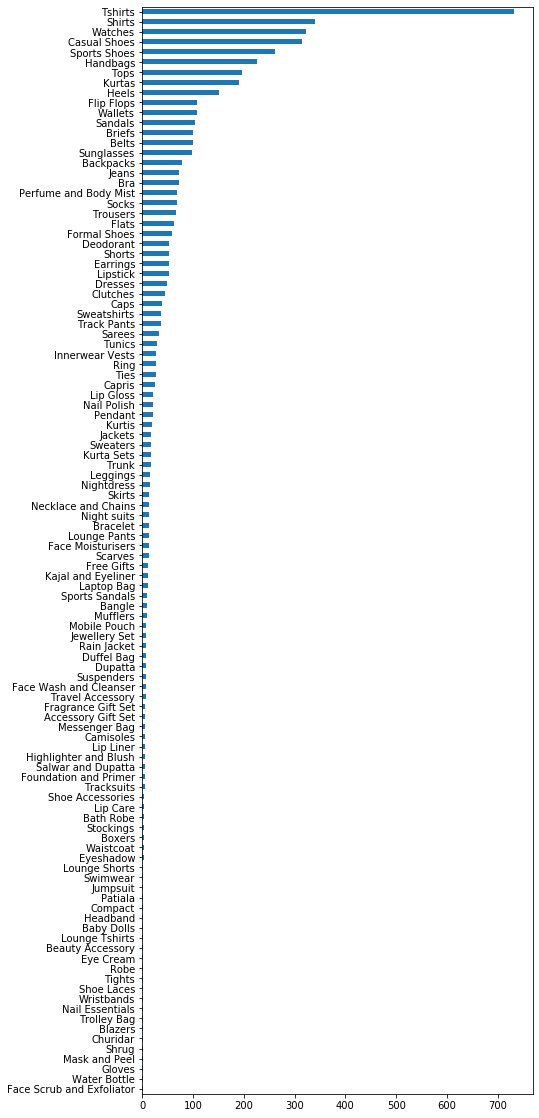

In [7]:
plt.figure(figsize=(7,20))
df.articleType.value_counts().sort_values().plot(kind='barh')

## Use Pre-Trained Model to Recommendation

In [8]:
import tensorflow as tf
import keras
from keras import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
tf.__version__

Using TensorFlow backend.


'2.1.0'

In [98]:
# Input Shape
img_width, img_height, _ = 224, 224, 3 #load_image(df.iloc[0].image).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

C:\Users\User\Anaconda3\envs\cnn\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [11]:
def get_embedding(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

Get item Embedding

In [12]:
emb = get_embedding(model, df.iloc[0].image)
emb.shape

(2048,)

(8, 6, 3)
[ 1.6955377  6.6482415  0.        ...  1.9520981  2.5550175 17.264183 ]


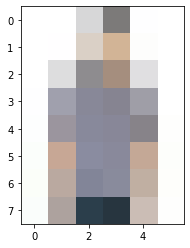

In [13]:
img_array = load_image(df.iloc[0].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

In [14]:
df.shape

(5000, 11)

Get Embedding for all itens in dataset

In [86]:
%%time
#import swifter

# Parallel apply
df_sample      = df#.sample(500)
map_embeddings = df_sample['image'].apply(lambda img: get_embedding(model, img))
df_embs        = map_embeddings.apply(pd.Series)

print(df_embs.shape)
df_embs.head()

(5000, 2048)
Wall time: 2min 2s


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,1.695538,6.648242,0.000000,1.927824,4.036982,3.737120,6.397761,8.110871,0.000000,0.547671,...,1.315518,5.438160,2.227734,23.199883,0.828266,0.000000,8.852712,1.952098,2.555017,17.264183
1,1.638368,12.644245,0.000000,6.099871,4.563685,0.000000,15.324889,1.945880,0.534093,0.000000,...,1.847894,7.822292,3.962158,7.593574,3.577689,0.000000,6.905621,0.000000,5.648772,16.628918
2,0.000000,1.653421,1.236328,4.655960,2.362137,4.077867,3.641308,1.355915,0.180239,4.034762,...,0.000000,15.896675,2.026925,1.756731,0.571142,0.000000,3.193866,2.299940,6.061993,5.402328
3,0.000000,5.168646,1.286177,10.286153,0.773860,0.000000,12.541208,7.041199,0.530163,2.544657,...,26.781736,1.221656,0.152611,0.000000,5.422546,1.292042,9.873067,0.000000,14.747469,15.182664
4,2.111657,14.036584,0.000000,2.014807,6.843655,2.104919,8.538333,6.723825,0.000000,0.000000,...,1.332445,5.887120,3.172086,18.849695,5.193437,0.000000,8.084830,1.996562,3.542353,16.738585


In [64]:
df_embs.to_csv(r'D:\machine-learning\data.csv')

In [69]:
df_embs = pd.read_csv(r'D:\machine-learning\data.csv')

#### Compute Similarity Between Items

![](http://dataaspirant.com/wp-content/uploads/2015/04/cosine.png)

In [87]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
from sklearn.metrics.pairwise import pairwise_distances

# Calcule DIstance Matriz
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')
cosine_sim[:4, :4]

array([[0.9999999 , 0.62557083, 0.4769969 , 0.5829124 ],
       [0.62557083, 1.        , 0.49236405, 0.73272884],
       [0.4769969 , 0.49236405, 0.99999946, 0.45782185],
       [0.5829124 , 0.73272884, 0.45782185, 0.9999996 ]], dtype=float32)

#### Recommender Similar Items

In [88]:
indices = pd.Series(range(len(df)), index=df.index)
indices

# Function that get movie recommendations based on the cosine similarity score of movie genres
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

get_recommender(133, df, top_n = 5)

(Int64Index([2453, 3601, 2883, 171, 4457], dtype='int64'),
 [0.8143908, 0.729933, 0.72110885, 0.71790725, 0.70889026])

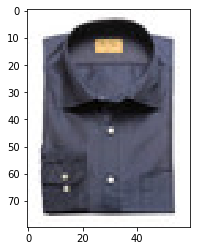

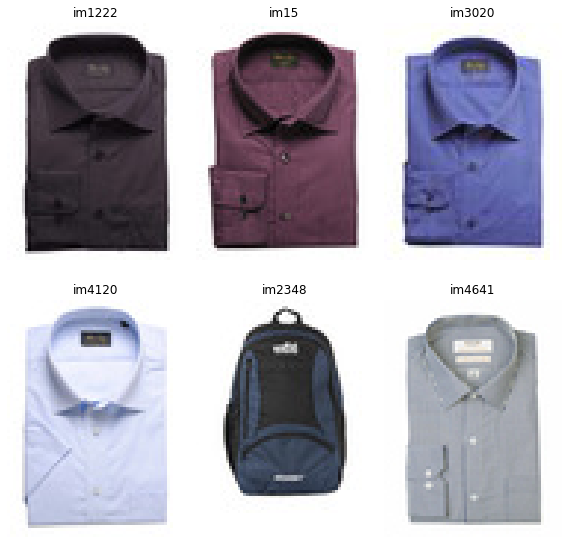

In [97]:
# Idx Item to Recommender
idx_ref = 3908


# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

**Search for items similar to the reference to recommend. Apparently it's working!**

In [ ]:
idx_ref = 878

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

In [ ]:
idx_ref = 987

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

In [ ]:
idx_ref = 3524

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

## Visualization Latent Space of Contents

Since our latent space is not two-dimensional, we will use TSNE to reduce dimensionality, so we can use some interesting visualizations that can be made at this point. One is to look at the neighborhoods of different classes in the latent 2D plane:

In [ ]:
from sklearn.manifold import TSNE
import time
import seaborn as sns

In [ ]:
df.head()

In [ ]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embs)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [ ]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

You can see different clusters generated by embeddings, which reinforces that features make sense. In this image above it is possible to observe the separation by Category, and in more detail by subcategory.

Of course there is actually a lot more information in embeddings, the visualization is for general understanding only

In [ ]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

## Conclusion

Convolutional networks can be used to generate generic embeddings of any content. These embeddings can be used to identify similar items and in a recommendation process.

A big improvement would be to retrain some network layers in a dataset similar to the one that will be used. So the network learns better features for a specific problem.

In [ ]:
df.sample(10).to_csv('df_sample.csv')
df_embs.to_csv('embeddings.csv')
df.to_csv('metadados.csv')